# Fundamentals of Quantization

Quantization has roots in information compression; in deep networks it refers to reducing the numerical precision of its weights and/or activations.

Overparameterized DNNs have more degrees of freedom and this makes them good candidates for information compression [1]. When you quantize a model, two things generally happen - the model gets smaller and runs with better efficiency. Hardware vendors explicitly allow for faster processing of 8-bit data (than 32-bit data) resulting in higher throughput. A smaller model has lower memory footprint and power consumption [2], crucial for deployment at the edge.

## Mapping function 🗺

The mapping function is a function that maps values from floating-point to integer space. A commonly used mapping function is a linear transformation give by

$$Q(r) = round(\dfrac{r}{S} + Z)$$

where $r$ is the input and $S,Z$ are quantization parameters.

To reconvert to floating point space the inverse function is given by $\tilde{r} = (Q(r) - Z) \cdot S$

$\tilde{r} \neq r$ and their difference constitues the quantization error.

## Quantization Parameters 💬

The mapping function is parameterized by the scaling factor $S$ and zero-point $Z$. $S$ is simply the ratio of the input range to the output range $S = \dfrac{\beta - \alpha}{\beta_q - \alpha_q}$, where $[\alpha, \beta]$ is the clipping range of the input. $[\alpha_q, \beta_q]$ is the range in the quantized output space that is mapped to. For 8-bit quantization, the output range $\beta_q - \alpha_q \leq (2^8 - 1).$ $Z$ acts as a bias to ensure that a 0 in the input space maps perfectly to a 0 in the quantized space. $Z = -(\dfrac{\alpha}{S} - \alpha_q)$.

## Calibration

The process of choosing the input clipping range is known as **calibration**. The simplest technique (also the default in PyTorch) is to record the running minimum and maximum values and assign them to $\alpha$ and $\beta$. TensorRT also used entropy minimization (KL divergence), mean-square-error minimization, or percentiles of the input range.

In `PyTorch`, `Observer` modules collect statistics on the input values and calculate the qparams $S, Z$. Difference calibration schemes result in different quantized outputs, and it's best to emperically verify which scheme works best for your application or architecture.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.quantization.observer import (
    MinMaxObserver,
    MovingAverageMinMaxObserver,
    HistogramObserver
)

C, L = 3, 4
normal = torch.distributions.normal.Normal(0,1)
inputs = [normal.sample((C, L)), normal.sample((C, L))]
print(inputs)

# >>>>>
# [tensor([[-0.0590,  1.1674,  0.7119, -1.1270],
#          [-1.3974,  0.5077, -0.5601,  0.0683],
#          [-0.0929,  0.9473,  0.7159, -0.4574]]]),

# tensor([[-0.0236, -0.7599,  1.0290,  0.8914],
#          [-1.1727, -1.2556, -0.2271,  0.9568],
#          [-0.2500,  1.4579,  1.4707,  0.4043]])]

observers = [
    MinMaxObserver(),
    MovingAverageMinMaxObserver(),
    HistogramObserver()
]
for obs in observers:
    for x in inputs: obs(x)
    print(obs.__class__.__name__, obs.calculate_qparams())

[tensor([[ 1.6783,  0.7324, -0.5548, -0.8003],
        [-0.7437,  0.3461,  0.8039,  1.2797],
        [ 0.8167,  0.2901, -1.3258,  0.4106]]), tensor([[-0.5927, -0.8348, -0.9573,  0.6720],
        [-0.4002, -1.4705,  0.5976,  1.4281],
        [ 0.4830, -0.4650,  0.5637, -1.5159]])]
MinMaxObserver (tensor([0.0125]), tensor([121], dtype=torch.int32))
MovingAverageMinMaxObserver (tensor([0.0118]), tensor([113], dtype=torch.int32))
HistogramObserver (tensor([0.0114]), tensor([132], dtype=torch.int32))


## Affine and Symmetric Quantization Schemes

**Affine of asymmetric quantization** schemes assign the input range to the min and max observed values. Affine schemes generally offer tighter clipping ranges and are useful for quantizing non-negative activations. The range is calculated as $\alpha = min(r), \beta = max(r)$. Affine quantization leads to more computationally expensive inference when used for weight tensors.

**Symmetric quantization** schemes center the input range around 0, eliminating the need to calculate zero-point offset. The range is calculated as $-\alpha = \beta = max(|max(r)|, |min(r)|)$. For skewed signals this can result in bad quantization resolution becasue the clipping range includes values that never show up in the input.$

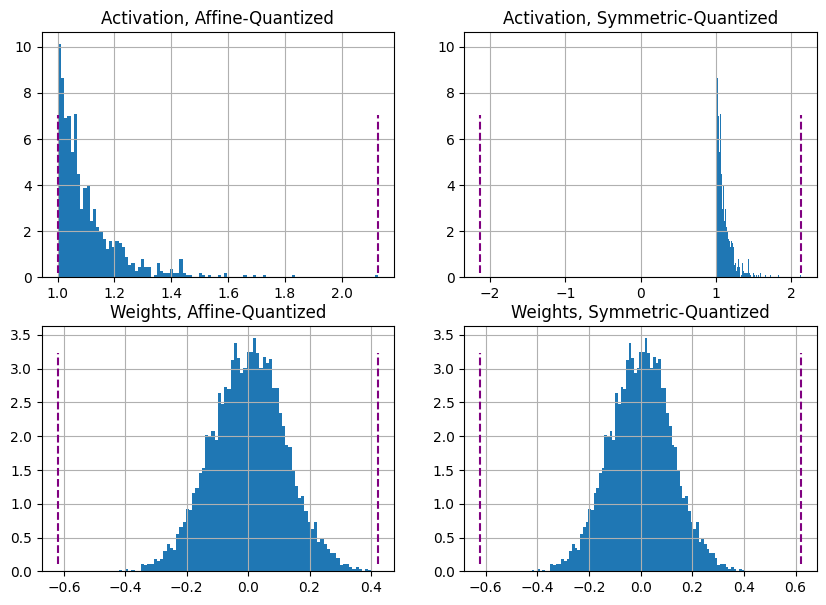

In [15]:
act = (
    torch.distributions.pareto.Pareto(1, 10).sample((1,1024))
)
weights = (
    torch
    .distributions
    .normal
    .Normal(0, 0.12)
    .sample((3, 64, 7, 7))
    .flatten()
)

def get_symmetric_range(x):
    beta = torch.max(x.max(), x.min().abs())
    return -beta.item(), beta.item()

def get_affine_range(x):
    return x.min().item(), x.max().item()

def plot(plt, data, scheme):
    boundaries = (
        get_affine_range(data) if scheme == 'affine'
        else get_symmetric_range(data)
    )
    a, _, _ = plt.hist(data, density=True, bins=100)
    ymin, ymax = np.quantile(a[a > 0], [0.25, 0.95])
    plt.vlines(x=boundaries, ls='--', colors='purple', ymin=ymin, ymax=ymax)

fig, axs = plt.subplots(2, 2, figsize=(10, 7))
plot(axs[0, 0], act, 'affine')
axs[0, 0].set_title("Activation, Affine-Quantized")
axs[0, 0].grid()

plot(axs[0, 1], act, 'symmetric')
axs[0, 1].set_title("Activation, Symmetric-Quantized")
axs[0, 1].grid()

plot(axs[1, 0], weights, 'affine')
axs[1, 0].set_title("Weights, Affine-Quantized")
axs[1, 0].grid()

plot(axs[1, 1], weights, 'symmetric')
axs[1, 1].set_title("Weights, Symmetric-Quantized")
axs[1, 1].grid()
plt.show()

fig.tight_layout()

### Post-Training Dynamic/Weight-only Quantization

Here the model's weights are pre-quantized; the activations are quantized on-the-fly during inference. The simplest of all approaches, it has a one line API call in `torch.quantization.quantize_dynamic`.

-  Can result in higher accuracies since the clipping range is exactly calibrated for each input
-  Dynamic quantization is preferred for models like LSTMs and Transformers where writing/retrieving the model's weights from memory dominate bandwidths
-  Calibrating and quantinzing activations at each layer during runtime can add to the compute overhead.